In [8]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import glob

In [7]:
#Creating a frame to contain data of all images and masks
frame_train = { 'image' : [], 'masked_image' : [] }
frame_test = { 'image': [], 'masked_image' : [] }

def LoadData(frame = None, imagePath = None, maskPath = None, shape = 256):
    """
    This method is used to load the image and masked image data and get the names
    """
    image_names = glob.glob(imagePath + '*.png')
    memogram_names = []
    mask_names = []
    file_names = []

    #Splitting all files
    file_names = list(set([name.split(')')[0] for name in image_names]))

    #from the files names segregrating memogram images and masked images into separate lists
    memogram_names = [name + ').png' for name in file_names]
    mask_names = [name + ')_mask.png' for name in file_names]

    #Reading each memogram and mask images using plt and resizing into 256*256 image and appending them to frame dictionary
    for i in range (len( memogram_names)):
        img = plt.imread(memogram_names[i])
        mask = plt.imread(mask_names[i])
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frame['image'].append(img)
        frame['masked_image'].append(mask)

    return frame

In [9]:
#loading data samples
frame_train_object = LoadData(frame_train, imagePath = './train/'
                       , maskPath = './data/'
                       , shape = 256)

frame_test_object = LoadData(frame_test, imagePath = './test/'
                       , maskPath = './data/'
                       , shape = 256)


In [10]:

def Convolutional2dBlock(input, filters, kernelSize = 3, doBatchNorm = True):
      """
      This method is to convolutional 2 dimensional block from the input
      It applies batch normalisation for the 2b block and applies activation function on the output
      Input : Input, filters, kernel sixe , batch normalisation flag
      """
      #Convolutional Layer 1:
      output = tf.keras.layers.Conv2D(filters = filters, kernel_size = (kernelSize, kernelSize),
                                kernel_initializer = 'he_normal', padding = 'same') (input)
      if doBatchNorm:
          output = tf.keras.layers.BatchNormalization()(output)
      output =tf.keras.layers.Activation('relu')(output)

      #Convolutional Layer 2:
      output = tf.keras.layers.Conv2D(filters = filters, kernel_size = (kernelSize, kernelSize),
                                kernel_initializer = 'he_normal', padding = 'same') (output)
      if doBatchNorm:
          output = tf.keras.layers.BatchNormalization()(output)
      output = tf.keras.layers.Activation('relu')(output)

      return output


In [11]:
#U-Net Method
def U_net_convolutional_neural_network(input_image, filters=16, dropouts=0.1, do_batch_norm=True):
    """
    This method is a Unet model which takes memogram images input
    U-Net is  Convolutional Neural Networks for Biomedical Image Segmentation"
    """

    # Encoder
    # Contracting path
    conv1 = Convolutional2dBlock(input_image, filters * 1, kernelSize=3, doBatchNorm=do_batch_norm)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    pool1 = tf.keras.layers.Dropout(dropouts)(pool1)

    conv2 = Convolutional2dBlock(pool1, filters * 2, kernelSize=3, doBatchNorm=do_batch_norm)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    pool2 = tf.keras.layers.Dropout(dropouts)(pool2)

    conv3 = Convolutional2dBlock(pool2, filters * 4, kernelSize=3, doBatchNorm=do_batch_norm)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    pool3 = tf.keras.layers.Dropout(dropouts)(pool3)

    conv4 = Convolutional2dBlock(pool3, filters * 8, kernelSize=3, doBatchNorm=do_batch_norm)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropouts)(pool4)

    #BottleNeck
    conv5 = Convolutional2dBlock(pool4, filters * 16, kernelSize=3, doBatchNorm=do_batch_norm)

    # Decoder
    # Expansive path
    # Upsampling and concatenation with skip connections
    up6 = tf.keras.layers.Conv2DTranspose(filters * 8, (3, 3), strides=(2, 2), padding='same')(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv4])
    up6 = tf.keras.layers.Dropout(dropouts)(up6)
    conv6 = Convolutional2dBlock(up6, filters * 8, kernelSize=3, doBatchNorm=do_batch_norm)

    up7 = tf.keras.layers.Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding='same')(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv3])
    up7 = tf.keras.layers.Dropout(dropouts)(up7)
    conv7 = Convolutional2dBlock(up7, filters * 4, kernelSize=3, doBatchNorm=do_batch_norm)

    up8 = tf.keras.layers.Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding='same')(conv7)
    up8 = tf.keras.layers.concatenate([up8, conv2])
    up8 = tf.keras.layers.Dropout(dropouts)(up8)
    conv8 = Convolutional2dBlock(up8, filters * 2, kernelSize=3, doBatchNorm=do_batch_norm)

    up9 = tf.keras.layers.Conv2DTranspose(filters * 1, (3, 3), strides=(2, 2), padding='same')(conv8)
    up9 = tf.keras.layers.concatenate([up9, conv1])
    up9 = tf.keras.layers.Dropout(dropouts)(up9)
    conv9 = Convolutional2dBlock(up9, filters * 1, kernelSize=3, doBatchNorm=do_batch_norm)

    #Output
    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    #Defining Unet Model
    model = tf.keras.Model(inputs=[input_image], outputs=[output])
    return model


In [12]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
transformer = U_net_convolutional_neural_network(inputs, dropouts= 0.07)
transformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

# Training For 50 Epochs

In [13]:
trained_model = transformer.fit(np.array(frame_train_object['image']), np.array(frame_train_object['masked_image']), epochs = 50, verbose = 0)

Training accuracy :  0.9831819534301758


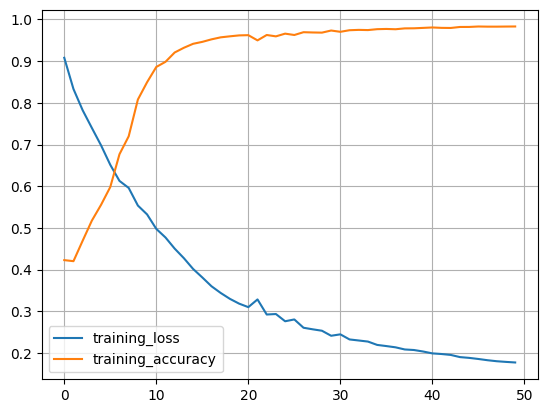

In [14]:
plt.plot(trained_model.history['loss'], label = 'training_loss')
plt.plot(trained_model.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

print("Training accuracy : ", end = ' ')
print(trained_model.history['accuracy'][-1])

# Testing

In [15]:
def predict (input, model, shape = 256):
    """
    This method is used to predict the mask for the memogram
    """
    image = input['image'][0:50]
    mask = input['masked_image'][0:50]
    image_processing = image [0:50]
    image_processing = np.array(image)
    predictions = model.predict(image_processing)
    return predictions, image_processing, mask


def Plotter(memogram, predicted_mask, actual_mask):
    """
    This method is used to visualise the predicted mask image and actual mask image along with the memogram
    Input : Memogram, predicted mask, actual mask
    """
    plt.figure(figsize=(9,9))
    plt.subplot(1,3,1)
    plt.imshow(memogram)
    plt.title(' image')
    plt.subplot(1,3,2)
    plt.imshow(predicted_mask)
    plt.title('Predicted mask')
    plt.subplot(1,3,3)
    plt.imshow(actual_mask)
    plt.title('Actual mask')

In [16]:
testing_model = transformer.fit(np.array(frame_test_object['image']), np.array(frame_test_object['masked_image']), epochs = 50, verbose = 0)

1/1 [==============================] - 3s 3s/step


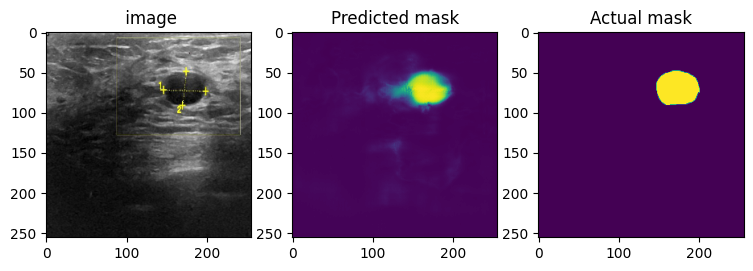

In [ ]:
predictions, actuals, masks = predict(frame_test_object, transformer)
Plotter(actuals[1], predictions[1][:,:,0], masks[1])

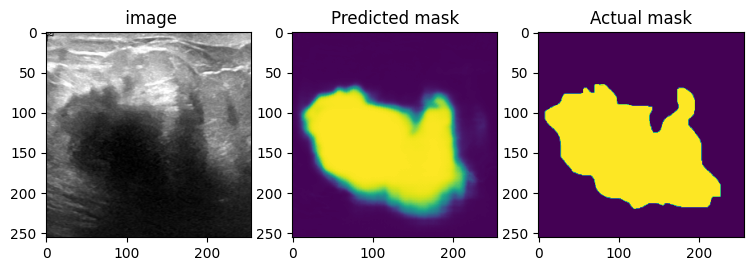

In [ ]:
Plotter(actuals[2], predictions[2][:,:,0], masks[2])

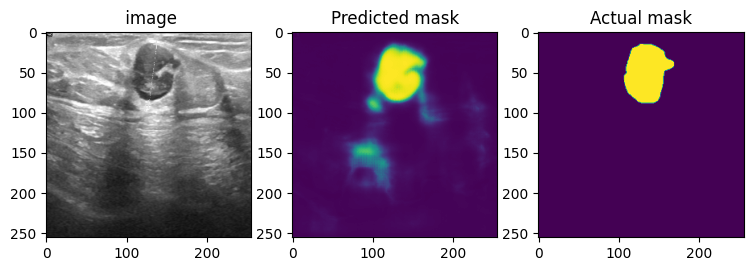

In [ ]:
Plotter(actuals[3], predictions[3][:,:,0], masks[3])

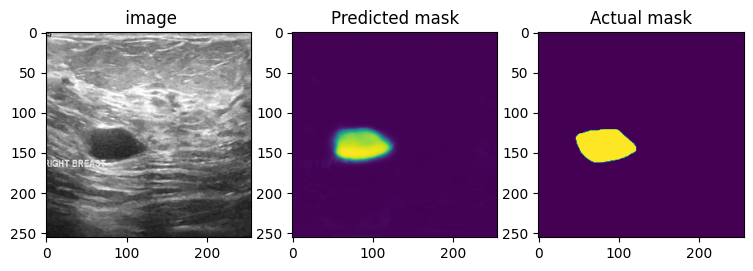

In [ ]:
Plotter(actuals[5], predictions[5][:,:,0], masks[5])

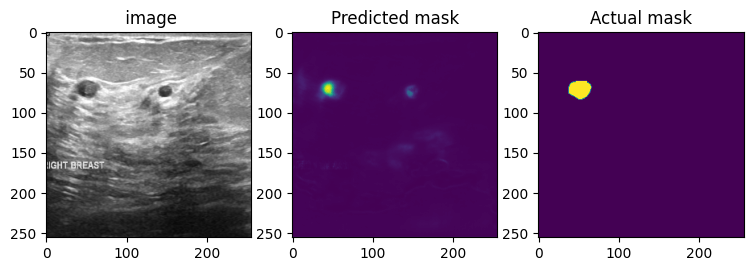

In [ ]:
Plotter(actuals[7], predictions[7][:,:,0], masks[7])

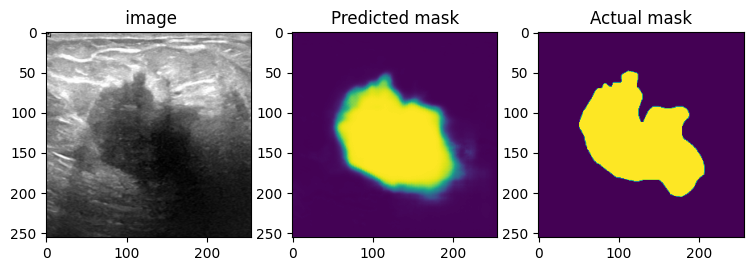

In [ ]:
Plotter(actuals[8], predictions[8][:,:,0], masks[8])

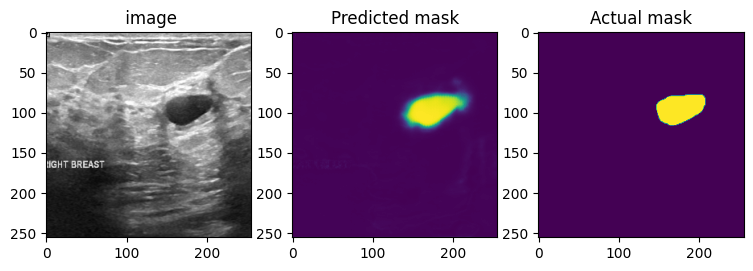

In [ ]:
Plotter(actuals[9], predictions[9][:,:,0], masks[9])

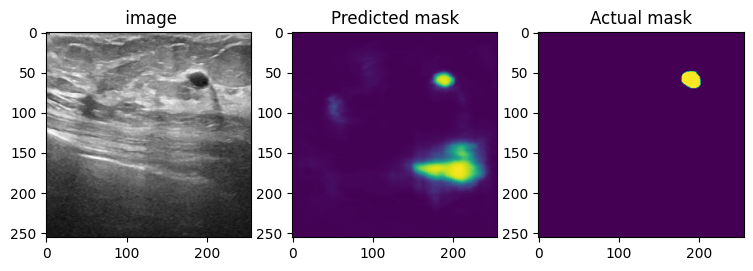

In [ ]:
Plotter(actuals[10], predictions[10][:,:,0], masks[10])

Testing accuracy :  0.991419792175293


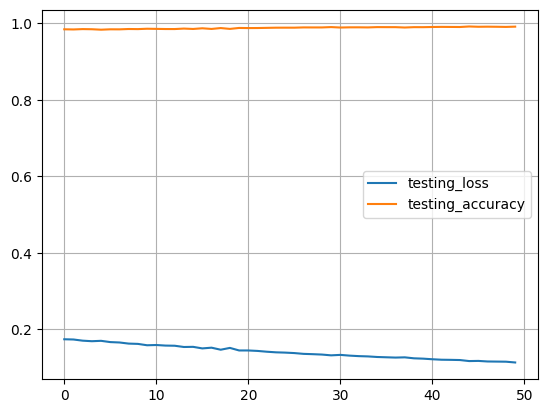

In [18]:
plt.plot(testing_model.history['loss'], label = 'testing_loss')
plt.plot(testing_model.history['accuracy'], label = 'testing_accuracy')
plt.legend()
plt.grid(True)

print("Testing accuracy : ", end = ' ')
print(testing_model.history['accuracy'][-1])

# Saving Model

In [ ]:
transformer.save('BreastCancerSegmentor.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
